In [22]:
pip show Pillow


Name: pillow
Version: 11.0.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: 
Author-email: "Jeffrey A. Clark" <aclark@aclark.net>
License: MIT-CMU
Location: /mnt/ExtraData/Github/365DaysOfData/venv/lib/python3.10/site-packages
Requires: 
Required-by: icrawler, matplotlib, streamlit, torchcam, torchvision
Note: you may need to restart the kernel to use updated packages.


# Training and evaluating - part 1: setup environment

In [2]:


import torch
import torchvision.transforms as transforms # for data transformations
from torch.utils.data import DataLoader # for loading data in batches
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os # for file operations

# set device to gpu if available else cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)


using device: cuda


In [1]:
import torchvision.models as models # for pre-trained models
from torch.utils.data import random_split # for splitting dataset
from torch import nn, optim # for defining model, loss function and optimizer
from torchvision.datasets import ImageFolder # for loading dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau # for learning rate scheduling
import time # for measuring time

# Part 2: Dataset setup and loading with augmentation


In [9]:
data_root = './eye_dataset/final'  # path to the dataset
train_dir = f"{data_root}/train"
val_dir = f"{data_root}/val"
test_dir = f"{data_root}/test"

train_transformms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transformms)

# Create validation set - either load from separate folder or split from train
try:
    val_dataset = ImageFolder(root=val_dir, transform=val_test_transforms)
except FileNotFoundError:
    # If no validation directory, split from training
    val_size = int(0.2 * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    # Apply transforms to validation split
    val_dataset.dataset.transform = val_test_transforms

# Load test dataset
test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Get class names - either from train_dataset or test_dataset based on which has classes attribute
if hasattr(train_dataset, 'classes'):
    class_names = train_dataset.classes
else:
    class_names = train_dataset.dataset.classes

print(f"Training on {len(train_dataset)} images")
print(f"Validating on {len(val_dataset)} images")
print(f"Testing on {len(test_dataset)} images")
print(f"Classes: {class_names}")

Training on 1196 images
Validating on 248 images
Testing on 277 images
Classes: ['barella', 'berkhamp', 'cruyff', 'cubarsi', 'cucurella', 'depaul', 'drogba', 'dumfries', 'etoo', 'gullit', 'ibrahimovic', 'kaka', 'mane', 'mbappe', 'messi', 'neymar', 'nunomendes', 'pedri', 'pele', 'pogba', 'puskas', 'raphina', 'ronaldo', 'salah', 'yamal']


# Part 3: Model setup and training functions


In [20]:
num_classes

25

In [ ]:
def get_model(num_classes):
    model = models.resnet18(pretrained=True)  # Load pre-trained ResNet18 model
    
    for param in list(model.parameters())[:20]: # Freeze first 20 layers
        param.requires_grad = False
    
    num_fits = model.fc.in_features
    model.fc = nn.Linear(num_fits, num_classes)  # Replace final layer to match number of classes
    
    return model

num_classes = len(class_names)
model = get_model(num_classes).to(device)


criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)  # Learning rate scheduler


/mnt/ExtraData/Github/365DaysOfData/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/ExtraData/Github/365DaysOfData/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/mnt/ExtraData/Github/365DaysOfData/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [14]:
# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

# Part 4: Training execution

Epoch 1/20
----------
Train Loss: 2.5603 Acc: 0.2517
Val Loss: 2.3450 Acc: 0.3024
Model saved with accuracy: 0.3024

Epoch 2/20
----------
Train Loss: 2.3605 Acc: 0.2952
Val Loss: 2.2681 Acc: 0.3629
Model saved with accuracy: 0.3629

Epoch 3/20
----------
Train Loss: 2.1116 Acc: 0.3478
Val Loss: 2.3732 Acc: 0.3185

Epoch 4/20
----------
Train Loss: 1.9198 Acc: 0.4197
Val Loss: 1.9977 Acc: 0.4597
Model saved with accuracy: 0.4597

Epoch 5/20
----------
Train Loss: 1.9209 Acc: 0.4222
Val Loss: 1.8920 Acc: 0.4919
Model saved with accuracy: 0.4919

Epoch 6/20
----------
Train Loss: 1.7984 Acc: 0.4741
Val Loss: 2.0350 Acc: 0.4516

Epoch 7/20
----------
Train Loss: 1.6257 Acc: 0.5259
Val Loss: 1.6454 Acc: 0.5685
Model saved with accuracy: 0.5685

Epoch 8/20
----------
Train Loss: 1.6191 Acc: 0.5100
Val Loss: 2.1397 Acc: 0.4798

Epoch 9/20
----------
Train Loss: 1.5066 Acc: 0.5577
Val Loss: 1.3840 Acc: 0.5927
Model saved with accuracy: 0.5927

Epoch 10/20
----------
Train Loss: 1.4483 Acc: 0.

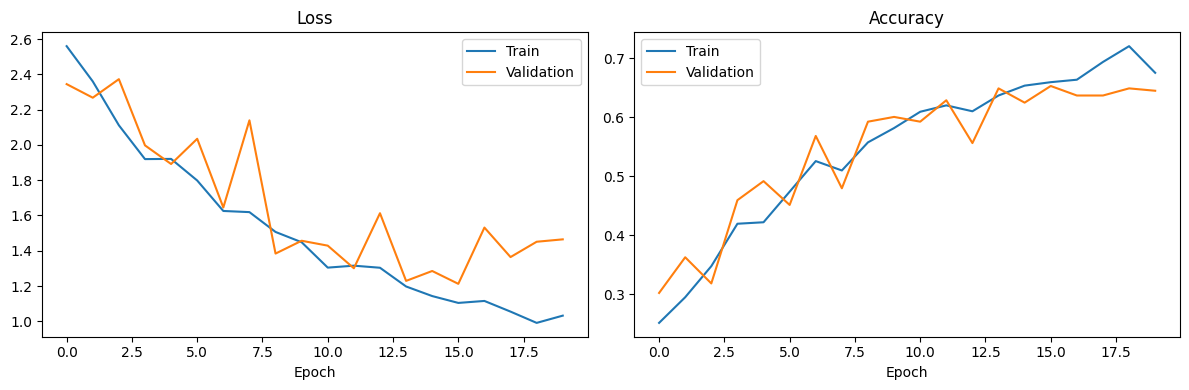

In [ ]:
# Part 5: Evaluation (fix the history saving issue first)

# Fix the training code to handle the accuracy values properly
# Training parameters
num_epochs = 25
best_val_acc = 0.0
patience = 5
early_stop_counter = 0
model_save_path = 'eye_classifier_resnet18.pth'

# History for plotting
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
start_time = time.time()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history - Fix: correctly handle tensor vs float types
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)  # train_acc is already a float
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())  # val_acc is a tensor, convert to float
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved with accuracy: {val_acc:.4f}')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    # Early stopping
    if early_stop_counter >= patience:
        print(f'Early stopping after {epoch+1} epochs')
        break
    
    print()

total_time = time.time() - start_time
print(f'Training complete in {total_time//60:.0f}m {total_time%60:.0f}s')
print(f'Best val Acc: {best_val_acc:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation code


/mnt/ExtraData/Github/365DaysOfData/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/ExtraData/Github/365DaysOfData/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_23080/284117774.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/

Test Loss: 1.1935, Test Acc: 0.6787

Classification Report:
              precision    recall  f1-score   support

     barella       0.67      0.73      0.70        11
    berkhamp       0.82      0.82      0.82        11
      cruyff       0.83      0.91      0.87        11
     cubarsi       1.00      0.62      0.77         8
   cucurella       0.60      0.92      0.73        13
      depaul       0.48      0.83      0.61        12
      drogba       0.36      0.42      0.38        12
    dumfries       0.80      0.50      0.62         8
        etoo       0.70      0.58      0.64        12
      gullit       0.73      0.67      0.70        12
 ibrahimovic       0.58      0.85      0.69        13
        kaka       0.57      0.53      0.55        15
        mane       0.67      0.44      0.53         9
      mbappe       0.80      0.62      0.70        13
       messi       0.75      0.50      0.60         6
      neymar       0.69      0.73      0.71        15
  nunomendes       0.

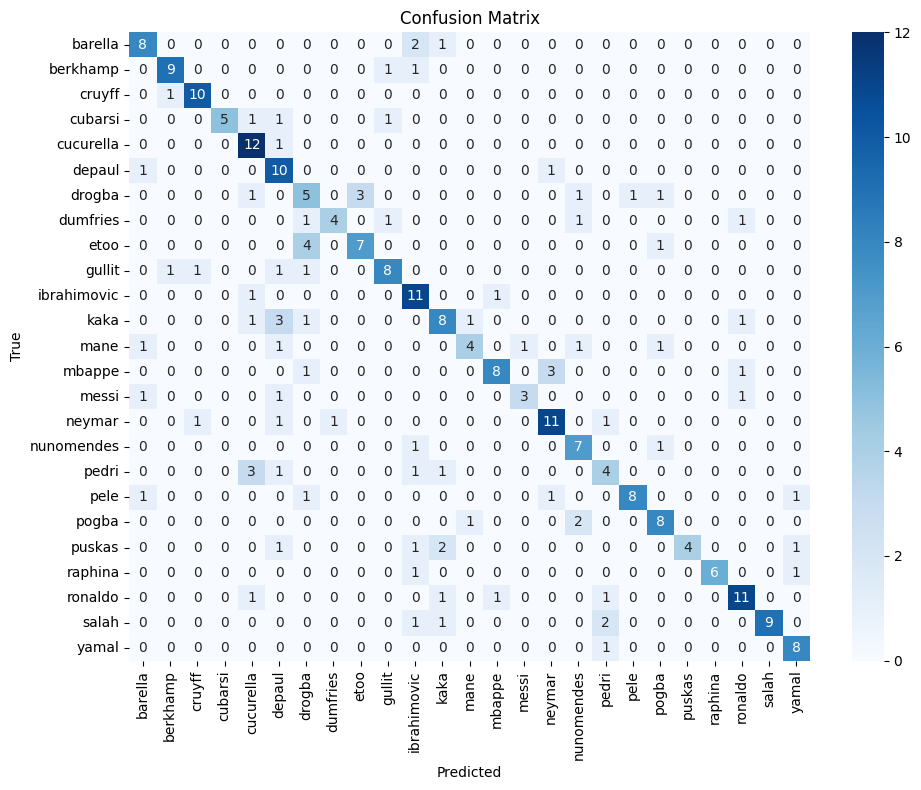

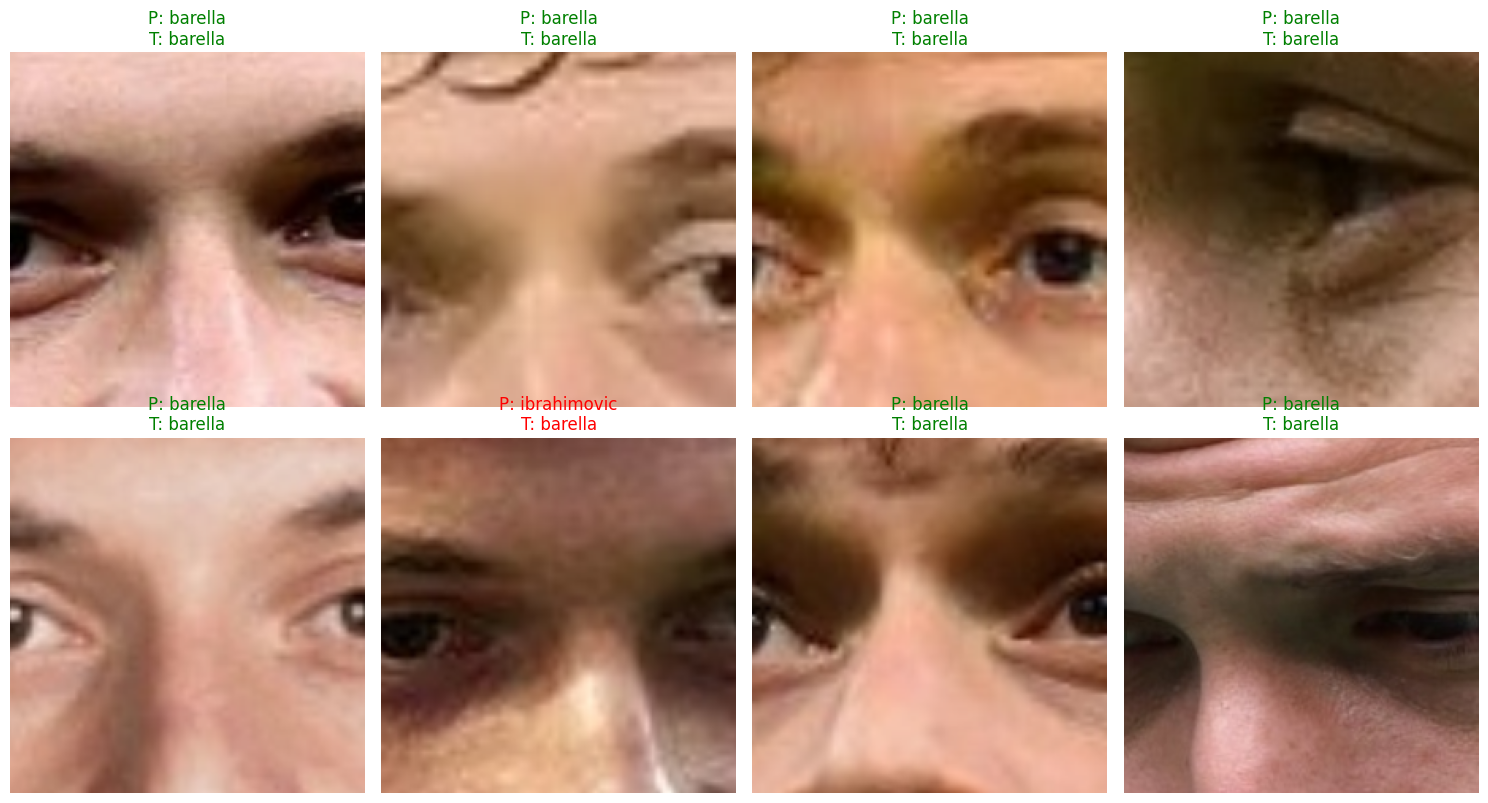

In [19]:

# Load the best model for evaluation
best_model = get_model(num_classes)
best_model.load_state_dict(torch.load(model_save_path, map_location=device))
best_model = best_model.to(device)
best_model.eval()

# Evaluate on test set
y_true = []
y_pred = []
test_loss = 0
test_correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        
        # Get predictions
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data).item()
        
        # Store for confusion matrix
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_loss = test_loss / len(test_dataset)
test_acc = test_correct / len(test_dataset)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Visualize some predictions
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = best_model(images.to(device))
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu()

# Plot images with predictions
plt.figure(figsize=(15, 8))
for i in range(min(8, len(images))):
    plt.subplot(2, 4, i+1)
    image = imshow(images[i])
    plt.imshow(image)
    color = 'green' if preds[i] == labels[i] else 'red'
    plt.title(f'P: {class_names[preds[i]]}\nT: {class_names[labels[i]]}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()